## Plot InSAR, GPS and seismicity data
Assumes that the data are located in  `$SCRATCHDIR` (e.g.  `$SCRATCHDIR/MaunaLoaSenDT87/mintpy`).
Output is  written into  `$SCRATCHDIR/MaunaLoa/SenDT87` and `$SCRATCHDIR/MaunaLoa/SenAT124`

Run all cells of this notebook for an example. The  plot options can be changed by editing the last `cmd = plot_data.py ...`  in the  cell of the `main` functions. Use -`-save-gbis` to save as GBIS files.

In [1]:
import os
import sys
import urllib
import csv
import glob
import re
import time
import datetime
import requests
import numpy as np
import pandas as pd
from pandas import concat
from pandas import DataFrame
from pathlib import Path
from dateutil.relativedelta import relativedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import contextily as ctx
import scipy.io as sio
from sklearn import datasets, linear_model
from datetime import datetime, timezone
from mintpy.utils import readfile, writefile, utils as ut
from mintpy.defaults.plot import *
from mintpy.objects.gps import search_gps, GPS
from mintpy.objects import sensor
from mintpy.view import prep_slice, plot_slice
from mintpy.cli import view, timeseries2velocity, reference_point, asc_desc2horz_vert, save_gdal, mask
from utils.helper_functions import is_jupyter, create_parser, cmd_line_parse, get_file_names
from utils.helper_functions import prepend_scratchdir_if_needed, find_nearest_start_end_date
from utils.helper_functions import get_data_type, get_dem_extent, save_gbis_plotdata
from utils.plot_functions import get_basemap, plot_shaded_relief
from utils.plot_functions import modify_colormap, add_colorbar
from utils.seismicity import get_earthquakes, normalize_earthquake_times
from utils.gps import get_gps
from utils.insar import generate_view_velocity_cmd, generate_view_ifgram_cmd
import subprocess

# %load_ext jupyter_ai
if 'ipykernel' in sys.modules:
    from IPython import get_ipython
    ipython = get_ipython()
    if 'autoreload' not in ipython.extension_manager.loaded:
        ipython.magic('load_ext autoreload')
        ipython.magic('autoreload 2')
else:
    pass

In [2]:
def run_prepare(inps):
    # Prepare data for plotting
    # Hardwired: move to argparse
    inps.depth_range="0 10"
    inps.cmap_name = "plasma_r"; inps.exclude_beginning = 0.2; inps.exclude_end = 0.2
    
    # Hardwired for Hawaii
    if 'GPSDIR' in os.environ:
        inps.gps_dir = os.getenv('GPSDIR') + '/data'
    else:
        inps.gps_dir = os.getenv('SCRATCHDIR') + '/MaunaLoa/MLtry/data'
    
    print('run_prepare: inps.gps_dir:' , inps.gps_dir)
    inps.gps_list_file = inps.gps_dir + '/GPS_BenBrooks_03-05full.txt'
    inps.dem_file = inps.gps_dir + '/demGeo.h5'  

    data_dir = inps.data_dir
    gps_dir = inps.gps_dir
    gps_list_file = inps.gps_list_file
    dem_file =  inps.dem_file
    plot_box = inps.plot_box
    flag_seismicity = inps.flag_seismicity
    flag_gps = inps.flag_gps
    plot_type = inps.plot_type
    line_file = inps.line_file
    gps_scale_fac = inps.gps_scale_fac
    gps_key_length = inps.gps_key_length
    gps_unit = inps.gps_unit
    unit = inps.unit
    font_size = inps.font_size
    reference_lalo = inps.reference_lalo
    mask_vmin = inps.mask_vmin
    vlim = inps.vlim
    flag_save_gbis =  inps.flag_save_gbis
    start_date = inps.period[0]
    end_date = inps.period[1]

    # calculate velocities for periods of interest
    data_dict = {}
    if plot_type == 'velocity' or plot_type == 'horzvert':
        for dir in data_dir:
            work_dir = prepend_scratchdir_if_needed(dir)
            eos_file, geo_vel_fie, geo_geometry_file, out_dir, out_geo_vel_file = get_file_names(work_dir)
            temp_coh_file=out_geo_vel_file.replace('velocity.h5','temporalCoherence.tif')
            start_date_mod, end_date_mod = find_nearest_start_end_date(eos_file, start_date, end_date)
            # get masked geo_velocity.h5 with MintPy
            # cmd = f'{eos_file} --start-date {start_date_mod} --end-date {end_date_mod} --output {out_geo_vel_file}'
            # timeseries2velocity.main( cmd.split() )
            cmd = f'{eos_file} --start-date {start_date_mod} --end-date {end_date_mod} --output {out_geo_vel_file}'
            cmd =['timeseries2velocity.py'] + cmd.split()
            output = subprocess.check_output(cmd)
            #print(output.decode())
            cmd = f'{eos_file} --dset temporalCoherence --output {temp_coh_file}'
            save_gdal.main( cmd.split() )
            cmd = f'{out_geo_vel_file} --mask {temp_coh_file} --mask-vmin { mask_vmin} --outfile {out_geo_vel_file}'
            mask.main( cmd.split() )

            timeseries2velocity
            
            gdal_inps = Namespace(fname=eos_file, dset='temporalCoherence', output=temp_coh_file)
            save_gdal(gdal_inps)
            mask_file(fname=out_geo_vel_file, mask=temp_coh_file, mask_vmin=mask_vmin, outfile=out_geo_vel_file)
    
            if reference_lalo:
                cmd = f'{out_geo_vel_file} --lat {reference_lalo[0]} --lon {reference_lalo[1]}'
                reference_point.main( cmd.split() )
            if flag_save_gbis:
                save_gbis_plotdata(eos_file, out_geo_vel_file, start_date_mod, end_date_mod)
            data_dict[out_geo_vel_file] = {
            'start_date': start_date_mod,
            'end_date': end_date_mod
            }
    elif plot_type == 'step':
        for dir in data_dir:
            work_dir = prepend_scratchdir_if_needed(dir)
            eos_file, geo_vel_file, geo_geometry_file, out_dir, out_geo_vel_file = get_file_names(work_dir)
            geo_step, atr = readfile.read(geo_vel_file, datasetName='step20210306')
            out_geo_step_file = out_geo_vel_file.replace('velocity','step')
            writefile.write(geo_step, out_file=out_geo_step_file, metadata=atr)
            if reference_lalo:
                cmd = f'{out_geo_step_file} --lat {reference_lalo[0]} --lon {reference_lalo[1]}'
                reference_point.main( cmd.split() )
            data_dict[out_geo_step_file] = {
            'start_date': atr['mintpy.timeFunc.stepDate'],
            'end_date': atr['mintpy.timeFunc.stepDate']
            }
    elif plot_type == 'shaded-relief':
        data_dict[dem_file] = {
        'start_date': start_date,
        'end_date': end_date
        }
 
    # calculate horizontal and vertical
    if  plot_type == 'horzvert':
        data_dict = {}
        q, q, q, q, out_geo_vel_file0 = get_file_names( prepend_scratchdir_if_needed(data_dir[0]) )
        q, q, q, q, out_geo_vel_file1 = get_file_names( prepend_scratchdir_if_needed(data_dir[1]) )
        
        cmd = f'{out_geo_vel_file0} {out_geo_vel_file1}'
        asc_desc2horz_vert.main( cmd.split() )
        data_dict['up.h5'] = {'start_date': start_date, 'end_date': end_date}
        data_dict['hz.h5'] = {'start_date': start_date, 'end_date': end_date}
    return data_dict

In [4]:
def run_plot(data_dict, inps):

    data_dir = inps.data_dir
    gps_dir = inps.gps_dir
    gps_list_file = inps.gps_list_file
    dem_file =  inps.dem_file
    plot_box = inps.plot_box
    flag_seismicity = inps.flag_seismicity
    flag_gps = inps.flag_gps
    plot_type = inps.plot_type
    line_file = inps.line_file
    gps_scale_fac = inps.gps_scale_fac
    gps_key_length = inps.gps_key_length
    gps_unit = inps.gps_unit
    unit = inps.unit
    font_size = inps.font_size
    reference_lalo = inps.reference_lalo
    mask_vmin = inps.mask_vmin
    vlim = inps.vlim
    flag_save_gbis =  inps.flag_save_gbis
    start_date = inps.period[0]
    end_date = inps.period[1]
    depth_range = inps.depth_range
    cmap_name = inps.cmap_name
    exclude_beginning = inps.exclude_beginning
    exclude_end = inps.exclude_end

    # initialize plot
    if len(data_dict) == 2:
        fig, axes = plt.subplots(1, 2, figsize=[12, 5] )
        inps.font_size = int(inps.font_size*0.7)  
    else:
        fig, axes = plt.subplots(figsize=[12, 5] )
        axes = [axes] 
        
    for i, (file, dict) in enumerate(data_dict.items()):
        axes[i].set_xlim(plot_box[2], plot_box[3])
        axes[i].set_ylim(plot_box[0], plot_box[1])
        
        if plot_type == 'velocity' or plot_type == 'horzvert' or plot_type == 'ifgram' or plot_type == 'step':
            if plot_type == 'velocity' or plot_type == 'horzvert' or plot_type == 'step':
                cmd = generate_view_velocity_cmd(file, inps) 
            elif plot_type == 'ifgram':
                cmd = generate_view_ifgram_cmd(work_dir, date12, inps)
            data, atr, tmp_inps = prep_slice(cmd)
            q0, q1, q2, q3 = plot_slice(axes[i], data, atr, tmp_inps)
        elif plot_type == 'shaded-relief':
            plot_shaded_relief(axes[i], file, plot_box = plot_box)
     # plot title
        data_type = get_data_type(file)
        axes[i].set_title(data_type + ': ' + dict['start_date'] + ' - ' + dict['end_date']);
     
        # plot fault lines
        if line_file:
            lines=sio.loadmat(line_file,squeeze_me=True);
            axes[i].plot(lines['Lllh'][:,0],lines['Lllh'][:,1],color='black', linestyle='dashed',linewidth=2)
     
        # plot events
        if flag_seismicity:
            events_df = get_earthquakes(start_date, end_date, plot_box)
            norm_times = normalize_earthquake_times(events_df, start_date, end_date)
            cmap = modify_colormap( cmap_name = cmap_name, exclude_beginning = exclude_beginning, exclude_end = exclude_end, show = False)
            if not events_df.shape[0] == 0:
                axes[i].scatter(events_df["Longitude"],events_df["Latitude"],s=2*events_df["Magnitude"] ** 3, c=norm_times,cmap=cmap,alpha=0.8)
            # plot scale only if there is only one plot (if there are no two plots)
            if  not ( len(data_dict.items()) == 2):
                add_colorbar(ax = axes[i], cmap = cmap, start_date = start_date, end_date = end_date)
        
        if flag_gps:
            gps,lon,lat,U,V,Z,quiver_label = get_gps(gps_dir, gps_list_file, plot_box, start_date, end_date, gps_unit, inps.gps_key_length)
            (gps_dir, gps_list_file, plot_box, start_date, end_date, gps_unit, gps_key_length)
            quiv=axes[i].quiver(lon, lat, U, V, scale = gps_scale_fac, color='blue')
            axes[i].quiverkey(quiv, -155.50, 19.57, gps_key_length*10 , quiver_label, labelpos='N',coordinates='data',
                              color='blue',fontproperties={'size': font_size}) 
    plt.show()


In [5]:
def main(iargs=None):
    os.chdir(os.getenv('SCRATCHDIR'))
    print('iargs', iargs)
    inps = cmd_line_parse(iargs)    
    print('inps:',inps)
    data_dict = run_prepare(inps)
    run_plot(data_dict, inps)
    
    # return data_dict, inps, iargs
    return None, None, None
###########################################################################################

if __name__ == '__main__':
    if is_jupyter():
        # in Jupyter, assign command line args to sys.argv
        cmd = 'plot_data.py --help'
        cmd = 'plot_data.py MaunaLoaSenDT87 --plot-type ifgram --seismicity --GPS'
        cmd = 'plot_data.py MaunaLoaSenDT87 --plot-type shaded_relief --seismicity --GPS'
        cmd = 'plot_data.py MaunaLoaSenAT124 MaunaLoaSenDT87 --noseismicity --GPS'
        cmd = 'plot_data.py MaunaLoaSenAT124 MaunaLoaSenDT87 --ref-point 19.55,-155.45'
        cmd = 'plot_data.py MaunaLoaSenDT87 --plot-type velocity'
        cmd = 'plot_data.py MaunaLoaSenDT87/mintpy_5_20 MaunaLoaSenAT124/mintpy_5_20 --plot-type horzvert --ref-point 19.55,-155.45 --mask-thresh 0.9'
        cmd = 'plot_data.py MaunaLoaSenDT87/mintpy_5_20 MaunaLoaSenAT124/mintpy_5_20 --plot-type horzvert --ref-point 19.55,-155.45 --period 20220801-20221127 --plot-box 19.43:19.5,-155.62:-155.55 --vlim -5 5 --save-gbis'
        cmd = 'plot_data.py --help'
        cmd = 'plot_data.py MaunaLoaSenDT87/mintpy_5_20 MaunaLoaSenAT124/mintpy_5_20 --plot-type velocity --ref-point 19.55,-155.45 --period 20220801-20221127 --vlim -20 20 --save-gbis --GPS --seismicity --fontsize 14'
        cmd = 'plot_data.py MaunaLoaSenDT87/mintpy_5_20  --plot-type shaded-relief --GPS --GPS-scale-fac 200 --GPS-key-length 1'
        cmd = 'plot_data.py MaunaLoaSenDT87/mintpy_5_20  --plot-type shaded-relief --GPS --seismicity'
        cmd = 'plot_data.py MaunaLoaSenDT87/mintpy_5_20  --plot-type shaded-relief --plot-box 19.43:19.5,-155.62:-155.55  --seismicity'
        cmd = 'plot_data.py GalapagosSenDT128/mintpy  --plot-type=velocity --plot-box=-0.52:-0.28,-91.7:-91.4 --period=20200131-20231231 --GPS --seismicity'
        cmd = 'plot_data.py GalapagosSenDT128/mintpy GalapagosSenAT106/mintpy_orig  --plot-type=horzvert --plot-box=-1.0:-0.75,-91.55:-91.25 --period=20190101-20230801 --vlim -5 5'
        cmd = 'plot_data.py GalapagosSenDT128/mintpy GalapagosSenAT106/mintpy_orig  --plot-type=horzvert --plot-box=-1.0:-0.75,-91.55:-91.25 --period=20220101-20230831 --vlim -5 5'
        # replace multiple spaces with a single space, remove trailing space
        cmd = re.sub(' +', ' ', cmd) 
        cmd = cmd.rstrip()
    
        sys.argv = cmd.split()

    print('Command:',sys.argv)
    data_dict, inps, sys.argv = main(sys.argv[1:])

Command: ['plot_data.py', 'GalapagosSenDT128/mintpy', 'GalapagosSenAT106/mintpy_orig', '--plot-type=horzvert', '--plot-box=-1.0:-0.75,-91.55:-91.25', '--period=20220101-20230831', '--vlim', '-5', '5']
iargs ['GalapagosSenDT128/mintpy', 'GalapagosSenAT106/mintpy_orig', '--plot-type=horzvert', '--plot-box=-1.0:-0.75,-91.55:-91.25', '--period=20220101-20230831', '--vlim', '-5', '5']
cmd_line_parse: iargs: ['GalapagosSenDT128/mintpy', 'GalapagosSenAT106/mintpy_orig', '--plot-type=horzvert', '--plot-box=-1.0:-0.75,-91.55:-91.25', '--period=20220101-20230831', '--vlim', '-5', '5']
cmd_line_parse: parser: ArgumentParser(prog='plot_data.py', usage=None, description='Plotting of InSAR, GPS and Seismicity data', formatter_class=<class 'argparse.HelpFormatter'>, conflict_handler='error', add_help=True)
cmd_line_parse: args: Namespace(data_dir=['GalapagosSenDT128/mintpy', 'GalapagosSenAT106/mintpy_orig'], plot_box='-1.0:-0.75,-91.55:-91.25', period='20220101-20230831', flag_seismicity=False, flag_

Exception: ('USER ERROR:  No date found later than ', 20230831)

In [74]:
inps

[]

In [44]:
INPS_DICT = {
    'plot_type': 'horzvert',
    'plot_box': '-1.0:-0.75,-91.55:-91.25',
    'period': '20220101-20230831',
    'vlim': (5,5),
}
INPS_DICT


{'plot_type': 'horzvert',
 'plot_box': '-1.0:-0.75,-91.55:-91.25',
 'period': '20220101-20230831',
 'vlim': (5, 5)}

In [47]:
class Namespace():
    def __init__(self, **kwargs):
        for key in kwargs:
            setattr(self, key, kwargs[key])


inps = Namespace(plot_type='horzvert',
                 plot_box = '-1.0:-0.75,-91.55:-91.25',
                 period='20220101-20230831',
                 vlim=(5,5),)

In [66]:
# class Person():
#     def __init__(self, name, last_name):
#         self.name = name
#         self.last_name = last_name
    
class Person():
    def __init__(self, **attributes):
        for key, value in attributes.items():
            setattr(self, key, value)
    def get_name(self):
        print(self.name)

        
best_human = Person(name='kawan',last_name='amelung', height = 33, skin=True)


In [68]:
def get_name(p):
    print(p.name)

dir(best_human)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'get_name',
 'height',
 'last_name',
 'name',
 'skin']

In [72]:
best_human.get_name()

kawan


In [33]:
class UserError(Exception):
    def __init__(self, text=''):
        message = "User Error from FA's shit code"
        if text != '':
            message = message + ": " + text
        super().__init__(message)

In [34]:
raise UserError

UserError: User Error from FA's shit code

In [35]:
raise UserError('Hdf5 file is empty!')

UserError: User Error from FA's shit code: Hdf5 file is empty!

In [11]:
class IdiotMessageError(Exception):
    def __init__(self, mssg=''):
        message = 'ya dumb!' + mssg
        super().__init__(message)
raise IdiotMessageError ('suupper dumb')

IdiotMessageError: ya dumb!suupper dumb

plot_data.py MaunaLoaSenDT87/mintpy_2_8_step  MaunaLoaSenAT124/mintpy_2_8_step --plot-type step --period 20201001-20210306 --ref-point 19.475,-155.6 --plot-box 19.43:19.5,-155.62:-155.55 --vlim -6 6
iargs ['MaunaLoaSenDT87/mintpy_2_8_step', 'MaunaLoaSenAT124/mintpy_2_8_step', '--plot-type', 'step', '--period', '20201001-20210306', '--ref-point', '19.475,-155.6', '--plot-box', '19.43:19.5,-155.62:-155.55', '--vlim', '-6', '6']
cmd_line_parse: iargs: ['MaunaLoaSenDT87/mintpy_2_8_step', 'MaunaLoaSenAT124/mintpy_2_8_step', '--plot-type', 'step', '--period', '20201001-20210306', '--ref-point', '19.475,-155.6', '--plot-box', '19.43:19.5,-155.62:-155.55', '--vlim', '-6', '6']
cmd_line_parse: parser: ArgumentParser(prog='plot_data.py', usage=None, description='Plotting of InSAR, GPS and Seismicity data', formatter_class=<class 'argparse.HelpFormatter'>, conflict_handler='error', add_help=True)
cmd_line_parse: args: Namespace(data_dir=['MaunaLoaSenDT87/mintpy_2_8_step', 'MaunaLoaSenAT124/mintpy

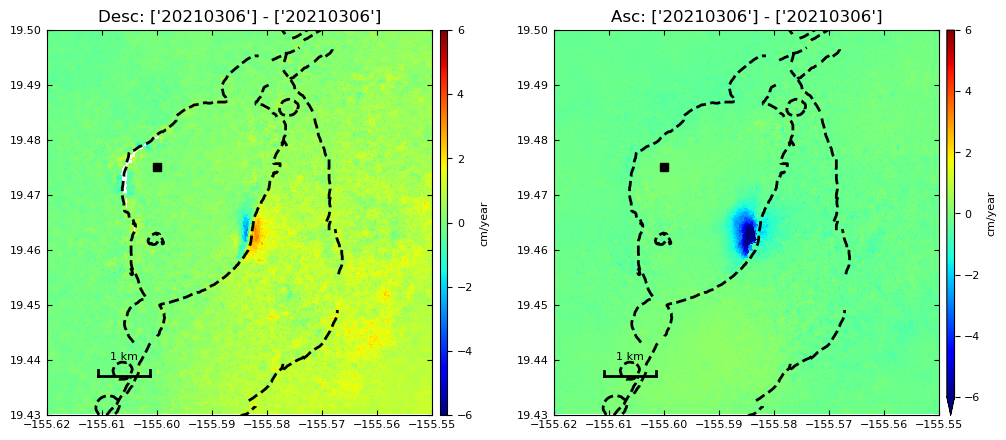

In [6]:
# DEBUG CELL: uncomment for access to inps, data_dict 
def main(iargs=None):
    print('iargs', iargs)
    inps = cmd_line_parse(iargs)    
    print('inps:',inps)
    data_dict = run_prepare(inps)
    run_plot(data_dict, inps)  
    return data_dict, inps, iargs

cmd = 'plot_data.py MaunaLoaSenDT87/mintpy_2_8_step  MaunaLoaSenAT124/mintpy_2_8_step --plot-type step --period 20201001-20210306 --ref-point 19.475,-155.6 --plot-box 19.43:19.5,-155.62:-155.55 --vlim -6 6'
print(cmd)
sys.argv = cmd.split()
data_dict, inps, sys.argv = main(sys.argv[1:])  

In [76]:
inps


Namespace(data_dir=['MaunaLoaSenDT87/mintpy_2_8_step', 'MaunaLoaSenAT124/mintpy_2_8_step'], plot_box=[19.43, 19.5, -155.62, -155.55], period=['20201001', '20210306'], flag_seismicity=False, flag_gps=False, plot_type='step', line_file='/Users/famelung/code/rsmas_insar/tools/plotdata/data/hawaii_lines_new.mat', gps_scale_fac=500, gps_key_length=4, gps_unit='cm', unit='cm', font_size=8, reference_lalo=[19.475, -155.6], mask_vmin=0.7, vlim=[-6.0, 6.0], flag_save_gbis=False, depth_range='0 10', cmap_name='plasma_r', exclude_beginning=0.2, exclude_end=0.2, gps_dir='/Users/famelung/onedrive/scratch/MaunaLoa/MLtry/data', gps_list_file='/Users/famelung/onedrive/scratch/MaunaLoa/MLtry/data/GPS_BenBrooks_03-05full.txt', dem_file='/Users/famelung/onedrive/scratch/MaunaLoa/MLtry/data/demGeo.h5')